In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [2]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'

In [3]:
!wget $data

--2025-10-20 15:16:32--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘course_lead_scoring.csv.1’

course_lead_scoring 100%[===================>]  78.98K  --.-KB/s    in 0.002s  

2025-10-20 15:16:32 (36.2 MB/s) - ‘course_lead_scoring.csv.1’ saved [80876/80876]



In [4]:
df = pd.read_csv('course_lead_scoring.csv')

In [5]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [6]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [7]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [8]:
categorical = list(df.dtypes[df.dtypes == 'object'].index)
categorical

['lead_source', 'industry', 'employment_status', 'location']

In [9]:
numerical = list(df.select_dtypes(include=['int64', 'float64']).columns)
numerical

['number_of_courses_viewed',
 'annual_income',
 'interaction_count',
 'lead_score',
 'converted']

In [10]:
numerical_features = [col for col in numerical if col != 'converted']
numerical_features

['number_of_courses_viewed',
 'annual_income',
 'interaction_count',
 'lead_score']

In [11]:
df[categorical] = df[categorical].fillna('NA')
df[numerical_features] = df[numerical_features].fillna(0.0)

In [12]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [13]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

In [14]:
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [15]:
len(df_train), len(df_val), len(df_test)

(876, 293, 293)

In [16]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [17]:
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

In [18]:
del df_train['converted']
del df_val['converted']
del df_test['converted']

In [42]:
from sklearn.metrics import roc_auc_score

In [43]:
auc_scores = {}

for feature in numerical_features:
    score = df_train[feature]
    auc = roc_auc_score(y_train, score)

    if auc < 0.5:
        score = -score
        auc = roc_auc_score(y_train, score)

    auc_scores[feature] = auc

for feature, auc in sorted(auc_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: AUC = {auc:.3f}")

number_of_courses_viewed: AUC = 0.764
interaction_count: AUC = 0.738
lead_score: AUC = 0.614
annual_income: AUC = 0.552


In [73]:
def train(df_train, y_train, C):
    dicts = df_train[categorical + numerical_features].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [74]:
def predict(df, dv, model):
    dicts = df[categorical + numerical_features].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [75]:
dv, model = train(df_train, y_train, C=1.0)

In [76]:
y_pred = predict(df_val, dv, model)

In [77]:
auc = roc_auc_score(y_val, y_pred)
print(f"AUC on validation dataframe: {auc:.3f}")


AUC on validation dataframe: 0.817


In [102]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [103]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

In [104]:
df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)

In [105]:
df_scores[::10]

,threshold,tp,fp,fn,tn,precision,recall
0,0.0,171,122,0,0,0.583618,1.000000
10,0.1,171,122,0,0,0.583618,1.000000
20,0.2,171,122,0,0,0.583618,1.000000
30,0.3,171,119,0,3,0.589655,1.000000
40,0.4,171,105,0,17,0.619565,1.000000
50,0.5,164,81,7,41,0.669388,0.959064
60,0.6,150,53,21,69,0.738916,0.877193
70,0.7,106,25,65,97,0.809160,0.619883
80,0.8,64,6,107,116,0.914286,0.374269
90,0.9,24,1,147,121,0.960000,0.140351


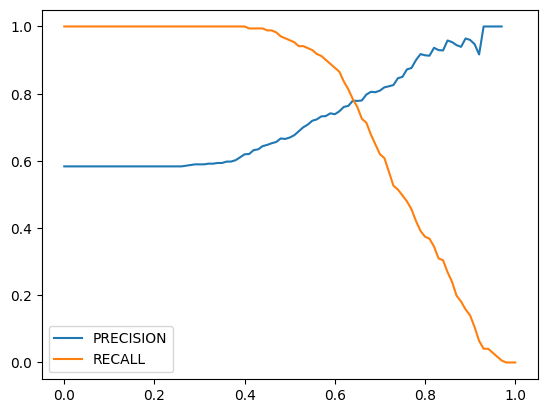

In [106]:
plt.plot(df_scores.threshold, df_scores['precision'], label='PRECISION')
plt.plot(df_scores.threshold, df_scores['recall'], label='RECALL')
plt.legend()

In [107]:
# df_scores['diff'] = (df_scores.precision - df_scores.recall).abs()
# intersection = df_scores.loc[df_scores['diff'].idxmin()]
# print(f"Threshold where precision ≈ recall: {intersection.threshold:.3f}")
df_scores['diff'] = (df_scores.precision - df_scores.recall).abs()
intersection = df_scores.loc[df_scores['diff'].idxmin()]
print(f"Threshold where precision ≈ recall: {intersection.threshold:.3f}")

Threshold where precision ≈ recall: 0.640


In [108]:
df_scores['f1'] = 2 * df_scores.precision * df_scores.recall / (df_scores.precision + df_scores.recall)
best_threshold = df_scores.loc[df_scores['f1'].idxmax()]
print(f"Best threshold by F1: {best_threshold.threshold:.2f}")

Best threshold by F1: 0.57
